# 6. Gyakorlat: Párbajozó dupla Q-tanulás
## Könyvtárak

In [1]:
import os
import gym
import random 
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque
from collections import namedtuple

mpl.rc('animation', html='jshtml')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
warnings.filterwarnings('ignore')

## Vizualizációs függvények

In [10]:
# Jeleneti változó beállítása
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

# Szekvenciális képkockák lejátszása egymás után
def plot_animation(frames, repeat = True, interval = 40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs = (frames, patch),
        frames = len(frames), repeat = repeat, interval = interval)
    plt.close()
    return anim

# Egy epizód lejátszása egy neurális hálózattal
def render_policy_net(agent, n_max_steps = 500, seed = 42, done_close = True, epsilon = 0):
    env = gym.make('LunarLander-v2', render_mode='rgb_array')
    s = env.reset()[0]
    frames = []
    rewards = []
    for step in range(n_max_steps):
        a = agent.act(s, 0.0)
        sp, r, done, info, _ = env.step(a) # Execute step
        rewards.append(r)
        frames.append(env.render())
        s = sp
        if(done_close and done):
            break

    env.close()
    return frames, rewards

# Jutalmak ábrázolása
def plot_rewards(rewards, episode = True):
    xlabel = 'Epizód' if episode else 'Lépés'
    df = pd.DataFrame({'Rewards': rewards, 'i': np.arange(len(rewards))})
    plt.figure(figsize = (6, 6))
    sns.lineplot(data=df, x = 'i', y = 'Rewards').set(title = f"Jutalom {len(rewards)} epizód alatt")
    plt.xlabel(xlabel)
    plt.ylabel('Jutalom')
    plt.show()

---
## $Q$-hálózat

In [3]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):  # Architektúra definíció
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)  # Input réteg
        
        self.fc_V = nn.Linear(64, 64)  # Teljesen becsatolt réteg az állapot-érték függvényhez
        self.out_V = nn.Linear(64, 1)  # V(s) output rétege

        self.fc_A = nn.Linear(64, 64)  # Teljesen becsatolt réteg az előny függvényhez
        self.out_A = nn.Linear(64, action_size)  # A(s,a) output rétege
        
    def forward(self, s):  # Előrecsatolás a neurális hálózat rétegeiben
        x = self.fc1(s)
        x = F.relu(x)

        # V(s) állapot-érték függvényhez tartozó predikció
        V = self.fc_V(x)
        V = F.relu(V)
        V = self.out_V(V)

        # Előny függvényhez tartozó becslés: A(s,a) = Q(s,a) - V(s)
        A = self.fc_A(x)
        A = F.relu(A)
        A = self.out_A(A)
        
        A_mean = torch.mean(A, dim=1, keepdim=True)
        Q = V + A - A_mean  # Q(s,a) kiszámítása az előnyből és az állapot-értékből

        return Q, V

---
## Tapasztalat visszajátszás

In [4]:
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size):
        self.action_size = action_size
        self.memory = deque(maxlen = buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=['s', 'a', 'r', 'sp', 'done'])
    
    def add(self, s, a, r, sp, done):
        e = self.experience(s, a, r, sp, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)  # Mintavétel egyenletes eloszlással

        states = torch.from_numpy(np.vstack([e.s for e in experiences if e is not None])).float()
        actions = torch.from_numpy(np.vstack([e.a for e in experiences if e is not None])).long()
        rewards = torch.from_numpy(np.vstack([e.r for e in experiences if e is not None])).float()
        next_states = torch.from_numpy(np.vstack([e.sp for e in experiences if e is not None])).float()
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float()
  
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.memory)

---
## Ügynök

In [5]:
class Agent():
    def __init__(self, state_size, action_size, buffer_size, batch_size, update_every, gamma, alpha, tau):
        self.tau = tau
        self.gamma = gamma
        self.alpha = alpha
        self.t_step = 0
        self.batch_size = batch_size
        self.state_size = state_size
        self.buffer_size = buffer_size
        self.action_size = action_size
        self.update_every = update_every
        self.action_stack = np.zeros([0, 2])
        self.local_model_name = 'checkpoint_DDDQN_local.pth'
        self.target_model_name = 'checkpoint_DDDQN_target.pth'
        self.state_stack = []

        self.qnetwork_local = QNetwork(state_size, action_size)  # Lokális hálózat (minden lépésben)
        self.qnetwork_target = QNetwork(state_size, action_size)  # Célhálózat (minden upadte_every lépéshez)
        self.memory = ReplayBuffer(action_size, buffer_size, batch_size)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr = alpha)
    
    def step(self, s, a, r, sp, done):
        self.memory.add(s, a, r, sp, done)  # Tapasztalat mentése a tapasztalat visszajátszási memóriába
        self.action_stack = np.vstack([self.action_stack, np.array([a, r])])
        self.t_step = (self.t_step + 1) % self.update_every  # Belső időlépés változó frissítése
        
        if self.t_step == 0 and len(self.memory) > self.batch_size:  # Ha van elég rekord a tapasztalat visszajátszásban mintavétel és tanulás
            experiences = self.memory.sample()  # Mintavétel a tapasztalat visszajátszásból
            self.learn(experiences)  # Ügynök tanítása

    def act(self, s, eps):  # Cselekvés választása az állapot alapján
        s = torch.from_numpy(s).float().unsqueeze(0)

        self.qnetwork_local.eval()  # Hálózat predikciós módba kapcsolása
        with torch.no_grad():  # Gradiens számítás kikapcsolása
            Q, V = self.qnetwork_local(s)  # Predikció a lokális hálózattal
        self.qnetwork_local.train()  # Hálózat tanító módba kapcsolása
        
        self.state_stack.append(V)  # Követési struktúra az állapot-értékekhez

        p = np.random.random()  # Véletlen szám 0 és 1 között
        if p < eps:  # Epszilon-mohó cselekvés választás
            return random.choice(np.arange(self.action_size))  # Véletlen cselekvés
        else:
            return np.argmax(Q.cpu().data.numpy())  # Legjobb ismert cselekvés

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences  # Tapasztalat kicsomagolása

        # Q-értékek kiszámítása
        target_action_value, _ = self.qnetwork_target(next_states)  # Cél Q-hálózat predikciója a következő állapotra
        q_targets_next = target_action_value.detach().max(1)[0].unsqueeze(1)  # Számítási gráfról lecsatlakoztatás és felesleges dimenzió eldobása
        q_targets = rewards + self.gamma * q_targets_next * (1 - dones)  # Q-értékek a következő állapotban
        local_action_value, _ = self.qnetwork_local(states)  # Lokális hálózat predikciója az aktuális állapotban a Q-értékekre
        q_expected = local_action_value.gather(1, actions)  # Q-értékek az aktuális állapotban
        
        # Költség számítása
        loss = F.mse_loss(q_expected, q_targets)  # Költség kiszámítása
        self.optimizer.zero_grad()  # Gradiensek törlése a számítási gráfról
        loss.backward()  # Hiba visszaáramoltatása a hálózatba
        self.optimizer.step()  # Lépés az optimalizálóval (paraméterek frissítése)

        self.soft_update(self.qnetwork_local, self.qnetwork_target)  # Célhálózat frissítése Polyak átlagolással

    def soft_update(self, local_model, target_model):  # Lágy frissítés Polyak átlagolással
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)  # Polyak átlagolás szerinti frissítés
    
    def save_model(self):
        torch.save(self.qnetwork_local.state_dict(), self.local_model_name)  # Lokális modell mentése
        torch.save(self.qnetwork_target.state_dict(), self.target_model_name)  # Cél modell mentése

---
## Tanítás

In [6]:
tau = 1e-3  # Polyak átlagolás paramétere
max_i = 3000  # Epizódok maximális száma
alpha = 5e-4  # Tanulási sebesség 
gamma = 0.99  # Diszkontálási faktor
max_t = 1000  # Egy epizódon belüli lépésszám
scores = []  # Jutalmak nyomon követése
eps_end = 0.01  # Felfedezési ráta végső értéke
eps_decay = 0.995  # Felfedezési ráta párologtatási együtthatója
eps_start = 1.0  # Felfedezési ráta kezdőértéke
batch_size = 64  # Kötegméret a tapasztalat visszajátszáshoz
buffer_size = int(1e5)  # Tapasztalat visszajátszás maximális mérete
update_every = 4  # Milyen gyakran frissüljön a célhálózat
scores_window = deque(maxlen = 100) # Keep track of the last 100 iterations
eps = eps_start  # Felfedezési ráta kezdőértékének megadása

env_name = 'LunarLander-v2'
env = gym.make(env_name)
print('Környezet : ', env.observation_space.shape)
print('Cselekvések száma: ', env.action_space.n)

agent = Agent(state_size = env.observation_space.shape[0], 
              action_size = env.action_space.n,
              buffer_size = buffer_size,
              batch_size = batch_size,
              update_every = update_every,
              gamma = gamma,
              alpha = alpha,
              tau = tau)

Környezet :  (8,)
Cselekvések száma:  4


In [7]:
for i in range(1, max_i + 1):  # Iteráció minden epizódra
    s = env.reset()[0]
    r_sum = 0

    for t in range(max_t):  # Iteráció minden lépésre az epizódon belül
        a = agent.act(s, eps)  # Ügynök állapotra adott cselekvése
        sp, r, done, info, _ = env.step(a)  # Következő állapot és jutalom megfigyelése
        agent.step(s, a, r, sp, done)  # Ügynök frissítése
        r_sum += r
        s = sp
        
        if done:
            break

    scores_window.append(r_sum)  # Legutóbbi kumulált jutalom elmentése
    scores.append(r_sum)  # Legutóbbi kumulált jutalom hozzáfűzése az összes jutalomhoz
    eps = max(eps_end, eps_decay * eps)  # Epszilon párologtatása
    
    if i % 100 == 0: # Every 100 episodes print out some data
        print(f'Epizód: {i}, Átlagos jutalom: {np.mean(scores_window)}')
        
    if np.mean(scores_window) >= 200.0: # Consider the task solved if the reward is over 200
        print(f'Környezet megoldva {i} epizód alatt')
        print(f'Átlagos pontszám: {np.mean(scores_window)}')
        agent.save_model()
        print('Modellek mentése sikeres')  
        break

Epizód: 100, Átlagos jutalom: -155.20158138227654
Epizód: 200, Átlagos jutalom: -85.17657542143577
Epizód: 300, Átlagos jutalom: -75.63100571386259
Epizód: 400, Átlagos jutalom: 76.3458933573581
Epizód: 500, Átlagos jutalom: 148.98903177323092
Epizód: 600, Átlagos jutalom: 143.42924452245106
Epizód: 700, Átlagos jutalom: 189.3304137774181
Környezet megoldva 719 epizód alatt
Átlagos pontszám: 200.83732052304916
Modellek mentése sikeres


## Jutalmak ábrázolása

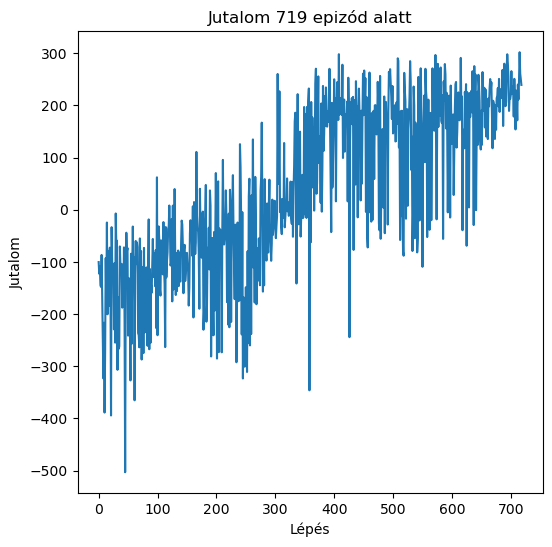

In [8]:
plot_rewards(scores, episode=False)

In [11]:
frames, rewards = render_policy_net(agent)
plot_animation(frames)

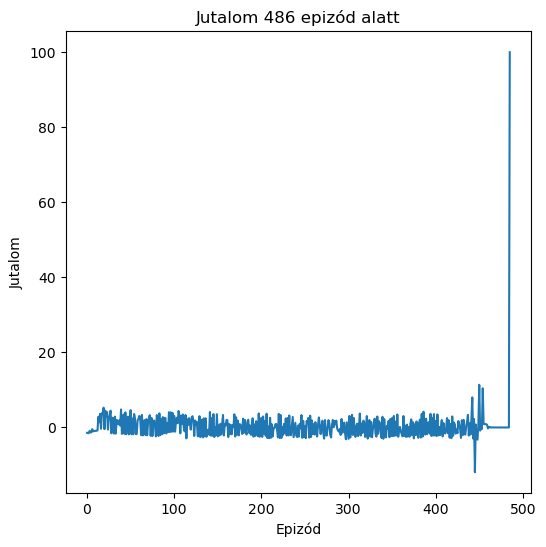

In [12]:
plot_rewards(rewards)

#### Jutalmak eloszlásának vizsgálata

In [13]:
df = pd.DataFrame(agent.action_stack, columns=['Action', 'Reward'])
df.to_csv('Action_stack_DDDQN.csv', sep=';', index=False)
df['Action'] = df['Action'].astype(np.int8)

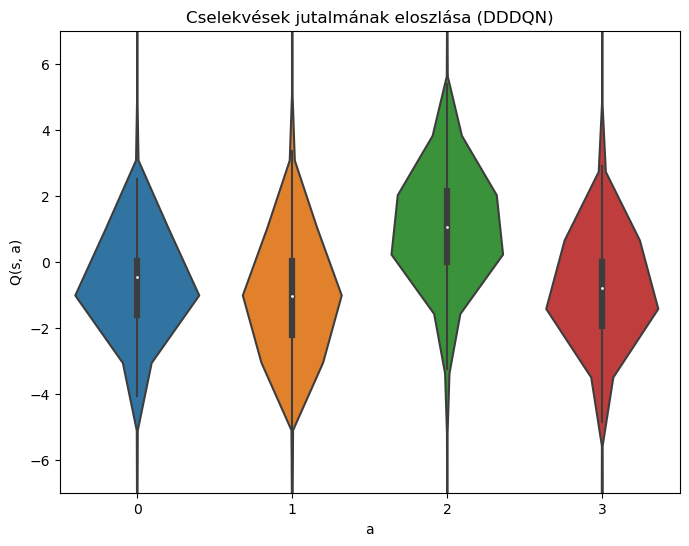

In [14]:
plt.figure(figsize=(8, 6))
plt.title("Cselekvések jutalmának eloszlása (DDDQN)")
ax = sns.violinplot(x='Action', y='Reward', data=df)
ax.set_xlabel("a")
ax.set_ylabel("Q(s, a)")
ax.set_ybound([-7,7])
plt.show()

#### Lépésenkénti állapot-érték vizsgálata

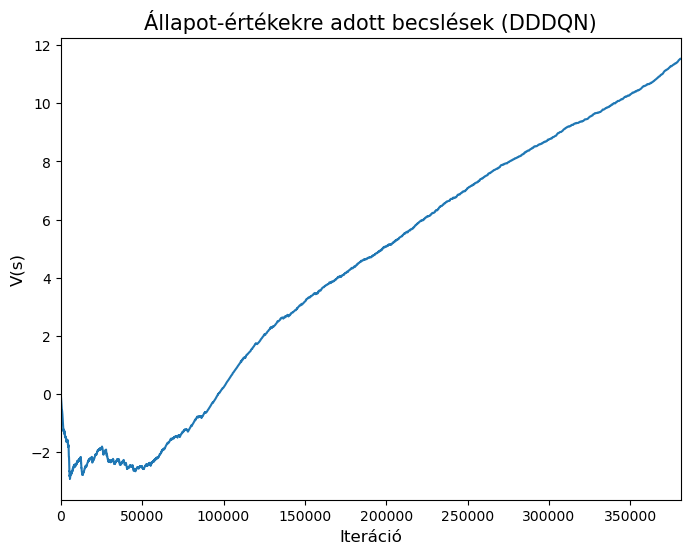

In [21]:
state_values = [tensor.item() for tensor in agent.state_stack]
state_stack_avg = np.cumsum(state_values) / (np.arange(len(state_values)) + 1)

plt.figure(figsize=(8, 6))
plt.plot(state_stack_avg)
plt.title("Állapot-értékekre adott becslések (DDDQN)",size=15)
plt.xlabel("Iteráció", size=12)
plt.ylabel("V(s)", size=12)
plt.xlim([0, len(state_stack_avg)])
plt.show()